In [24]:
!pip install mysql-connector



In [25]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mysql.connector
from google.colab import files
from sqlalchemy import create_engine

In [26]:
connection = mysql.connector.connect(
    host='34.128.108.220',
    user='root',
    password='sehatin-db-password',
    database='sehatin'
)

In [27]:
cursor = connection.cursor()

# Check if the 'sehatin' database exists
cursor.execute("SHOW DATABASES LIKE 'sehatin'")
database_exists = cursor.fetchone()

if database_exists:
    print("Database 'sehatin' exists.")

    # Switch to the 'sehatin' database
    cursor.execute("USE sehatin")

    # Check if the 'eat_log' table exists
    cursor.execute("SHOW TABLES LIKE 'eat_logs'")
    table_exists = cursor.fetchone()

    if table_exists:
        print("Table 'eat_logs' exists.")
    else:
        print("Table 'eat_logs' does not exist.")
else:
    print("Database 'sehatin' does not exist.")

# Close the cursor and connection
cursor.close()


Database 'sehatin' exists.
Table 'eat_logs' exists.


True

In [74]:
import pandas as pd
import mysql.connector

USER_ID = "ed32b89372f8"
# Define the database connection parameters
db_config = {
    'host': '34.128.108.220',
    'user': 'root',
    'password': 'sehatin-db-password',
    'database': 'sehatin'
}

# Establish a connection to the database
connection = mysql.connector.connect(**db_config)

# Create a cursor object
cursor = connection.cursor()

# Define your SQL query with a placeholder for the user_id
sql_query = "SELECT * FROM eat_logs WHERE user_id = %s"

# Execute the SQL query with the user_id as a parameter
cursor.execute(sql_query, (USER_ID,))
result = cursor.fetchall()

# Create a DataFrame from the query result
df = pd.DataFrame(result, columns=cursor.column_names)
df['date'] = pd.to_datetime(df['date'])

# Remove 'days' part from 'time' and convert to timedelta
df['time'] = pd.to_timedelta(df['time'].astype(str).str.replace(' days ', ' ').str.replace(' day ', ' '))

# Combine 'date' and 'time' columns to create 'Timestamp'
df['Timestamp'] = df['date'] + df['time']

# Calculate the time difference between rows
df['Selisih'] = df['Timestamp'].diff()

# Convert time difference to hours
df['Selisih'] = df['Selisih'].dt.total_seconds() / 3600

# Initialize 'Pesan' column
df['Pesan'] = None
# Display the DataFrame
print(df)

for i in range(1, len(df)):
    if df['calories'][i] >= 210 and df['calories'][i-1] >= 210 and df['Selisih'][i] > 5/60:
        if df['Selisih'][i] < 3:
            df.at[i, 'Pesan'] = 'Rentang waktu makan kurang dari 3 jam'
        elif df['Selisih'][i] > 5:
            df.at[i, 'Pesan'] = 'Rentang waktu makan lebih dari 5 jam'
    else:
        df.at[i, 'Pesan'] = "Rentang waktu makan yang baik"

print(df)


# Close the cursor and connection
cursor.close()
connection.close()


             id       user_id            food   portion  calories  carbs  \
0  a1347b90e57c  ed32b89372f8      Brown Rice     1 cup     215.0  45.08   
1  b0218f50d96a  ed32b89372f8           Tempe     1 ons      55.0   9.39   
2  c2596d78f23e  ed32b89372f8  Chicken Breast     4 ons     187.0   0.00   
3  d3850e14a79f  ed32b89372f8        Broccoli     1 cup      55.0  11.20   
4  e4931f67b02d  ed32b89372f8          Salmon     6 ons     367.0  12.00   
5  f5062c89d31a  ed32b89372f8            Tahu  100 gram      80.0   1.90   
6  g6173a82e54b  ed32b89372f8        Kangkung  200 gram      28.0   3.90   

   prots  fats message       date            time           Timestamp  \
0   5.03   1.6    None 2023-12-16 0 days 13:46:46 2023-12-16 13:46:46   
1  18.54  10.8    None 2023-12-15 0 days 17:26:56 2023-12-15 17:26:56   
2  39.30   3.6    None 2023-12-18 0 days 14:46:46 2023-12-18 14:46:46   
3   3.70   0.6    None 2023-12-19 0 days 15:58:43 2023-12-19 15:58:43   
4  40.60  22.4    None 202

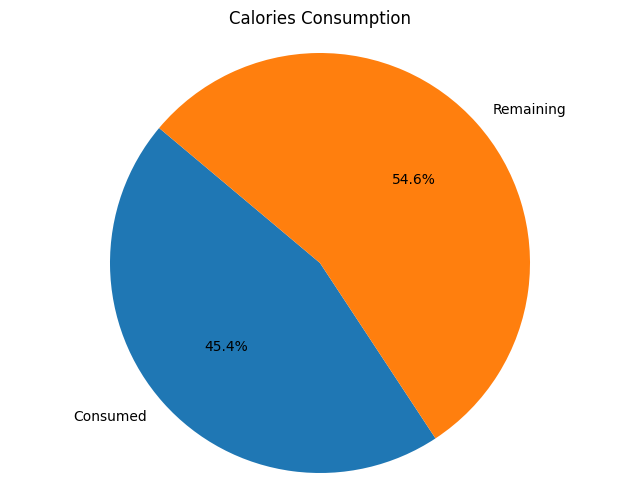

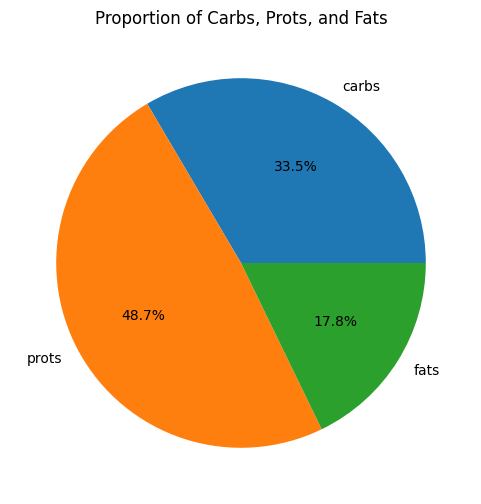

In [79]:
total = df[['calories', 'carbs', 'prots', 'fats']].sum()
total_macro = total[['carbs', 'prots', 'fats']]
# Establish a connection to the database
connection = mysql.connector.connect(**db_config)

# Create a cursor object
cursor = connection.cursor()
# Define your SQL query with a placeholder for the user_id
sql_query = "SELECT * FROM users_data WHERE user_id = %s"

# Execute the SQL query with the user_id as a parameter
cursor.execute(sql_query, (USER_ID,))
result = cursor.fetchall()

# Create a DataFrame from the query result
df2 = pd.DataFrame(result, columns=cursor.column_names)
recommended_calories = df2[['bmr']]
# Pie chart for calories
remaining_calories = max(0, recommended_calories['bmr'].values[0] - total['calories'])
calories_sizes = [total['calories'], remaining_calories]

plt.figure(figsize=(8, 6))
plt.pie(calories_sizes, labels=['Consumed', 'Remaining'], autopct='%1.1f%%', startangle=140)
plt.title('Calories Consumption')
plt.axis('equal')
plt.show()

# Create a pie chart for macronutrients proportion
plt.figure(figsize=(6, 6))
plt.pie(total_macro, labels=total_macro.index, autopct='%1.1f%%')
plt.title('Proportion of Carbs, Prots, and Fats')
plt.show()

# Calculate the total amount of carbs, proteins, and fats over all days
total_carbs = df['carbs'].sum()
total_prots = df['prots'].sum()
total_fats = df['fats'].sum()

# Calculate the total amount of these three macronutrients
total_all = total_carbs + total_prots + total_fats

# Calculate the proportion of each macronutrient
carbs_prop = total_carbs / total_all
prots_prop = total_prots / total_all
fats_prop = total_fats / total_all

# Check if the proportion of each macronutrient is within the AMDR
if not 0.45 <= carbs_prop <= 0.65:
    print('Warning: The proportion of carbs is out of the acceptable range (45–65%).')
elif not 0.20 <= fats_prop <= 0.35:
    print('Warning: The proportion of fats is out of the acceptable range (20–35%).')
elif not 0.10 <= prots_prop <= 0.35:
    print('Warning: The proportion of protein is out of the acceptable range (10–35%).')
else:
    print('You have a good proportion of carbohydrate, protein and fat.')